# Mnist

In [1]:
import tempfile
import os

import tensorflow as tf
import numpy as np

from tensorflow import keras

In [2]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture.
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(
  train_images,
  train_labels,
  epochs=4,
  validation_split=0.1,
)


Train on 54000 samples, validate on 6000 samples
Epoch 1/4
54000/54000 [==============================] - 7s 128us/sample - loss: 0.3234 - accuracy: 0.9092 - val_loss: 0.1540 - val_accuracy: 0.9572
Epoch 2/4
54000/54000 [==============================] - 5s 101us/sample - loss: 0.1437 - accuracy: 0.9598 - val_loss: 0.0960 - val_accuracy: 0.9748
Epoch 3/4
54000/54000 [==============================] - 5s 101us/sample - loss: 0.0984 - accuracy: 0.9718 - val_loss: 0.0818 - val_accuracy: 0.9767
Epoch 4/4
54000/54000 [==============================] - 6s 108us/sample - loss: 0.0770 - accuracy: 0.9780 - val_loss: 0.0738 - val_accuracy: 0.9783


In [3]:
_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)


Baseline test accuracy: 0.9776
Saved baseline model to: /tmp/tmpb7vl6dij.h5


# 2. basline model with only pruning

In [6]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 4 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.90,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_reshape  (None, 28, 28, 1)         1         
_________________________________________________________________
prune_low_magnitude_conv2d ( (None, 26, 26, 12)        230       
_________________________________________________________________
prune_low_magnitude_max_pool (None, 13, 13, 12)        1         
_________________________________________________________________
prune_low_magnitude_flatten  (None, 2028)              1         
_________________________________________________________________
prune_low_magnitude_dense (P (None, 10)                40572     
Total params: 40,805
Trainable params: 20,410
Non-trainable params: 20,395
_________________________________________________________________


In [7]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
model_for_pruning.fit(train_images, train_labels,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Train on 54000 samples, validate on 6000 samples
Epoch 1/2
54000/54000 [==============================] - 5s 86us/sample - loss: 0.1125 - accuracy: 0.9671 - val_loss: 0.0987 - val_accuracy: 0.9720
Epoch 2/2
54000/54000 [==============================] - 4s 66us/sample - loss: 0.1127 - accuracy: 0.9675 - val_loss: 0.1172 - val_accuracy: 0.9675


In [8]:


_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)



Baseline test accuracy: 0.9776
Pruned test accuracy: 0.9623


In [9]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /tmp/tmp__rlz5_8.h5


# 3-1. baseline model with only quantizing

In [10]:
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quant_reshape (QuantizeWrapp (None, 28, 28, 1)         1         
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 26, 26, 12)        147       
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 13, 13, 12)        1         
_________________________________________________________________
quant_flatten (QuantizeWrapp (None, 2028)              1         
_________________________________________________________________
quant_dense (QuantizeWrapper (None, 10)                20295     
Total params: 20,445
Trainable params: 20,410
Non-trainable params: 35
_________________________________________________________________


In [11]:
train_images_subset = train_images[0:1000] # out of 60000
train_labels_subset = train_labels[0:1000]

q_aware_model.fit(train_images_subset, train_labels_subset,
                  batch_size=500, epochs=1, validation_split=0.1)


Train on 900 samples, validate on 100 samples
900/900 [==============================] - 1s 573us/sample - loss: 0.2224 - accuracy: 0.9644 - val_loss: 0.2870 - val_accuracy: 0.9600


In [12]:
_, q_aware_model_accuracy = q_aware_model.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)

Baseline test accuracy: 0.9776
Pruned test accuracy: 0.9623
Quant test accuracy: 0.9566


In [13]:
_, quantized_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(q_aware_model, quantized_keras_file, include_optimizer=False)
print('Saved quantized Keras model to:', quantized_keras_file)

Saved quantized Keras model to: /tmp/tmptx_umyxs.h5


# 3-2. baseline model with post-quatizing

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
post_quan_tflite_model = converter.convert()

_,post_quan_tflite_file = tempfile.mkstemp('.tflite')

In [15]:
print('Saved post-quantized TFLite model to:',post_quan_tflite_file)

Saved post-quantized TFLite model to: /tmp/tmp0xtd12ut.tflite


In [16]:
# tflite 정확도 측정 함수
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels).mean()
  return accuracy

In [17]:
interpreter_post_q = tf.lite.Interpreter(model_content=post_quan_tflite_model)
interpreter_post_q.allocate_tensors()

test_post_q_accuracy = evaluate_model(interpreter_post_q)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.




In [18]:
print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)
print('Post-Quant test accuracy:', test_post_q_accuracy)



Baseline test accuracy: 0.9776
Pruned test accuracy: 0.9623
Quant test accuracy: 0.9566
Post-Quant test accuracy: 0.9617


# 4. pruned model and quantized model convert to TFLite

### pruned model convert to tflite_model

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

Saved pruned TFLite model to: /tmp/tmp_at0c82h.tflite


### quantized model convert to tflite_model

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
quantized_tflite_model = converter.convert()

_, quantized_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_tflite_file, 'wb') as f:
    f.write(quantized_tflite_model)

print('Saved quantized TFLite model to:', quantized_tflite_file)


Saved quantized TFLite model to: /tmp/tmpqbzhywf6.tflite


In [21]:
interpreter_p = tf.lite.Interpreter(model_content=pruned_tflite_model)
interpreter_q = tf.lite.Interpreter(model_content=quantized_tflite_model)

interpreter_p.allocate_tensors()
interpreter_q.allocate_tensors()

test_accuracy_p = evaluate_model(interpreter_p)
test_accuracy_q = evaluate_model(interpreter_q)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.




In [22]:
print('Baseline test accuracy:', baseline_model_accuracy,"\n")
print('Pruned test accuracy:', model_for_pruning_accuracy,"\n")
print('Quant test accuracy:', q_aware_model_accuracy,"\n")
print('Post-Quant test accuracy:', test_post_q_accuracy,"\n")
print('Prun TFLite test_accuracy:', test_accuracy_p,"\n")
print('Quant TFLite test_accuracy:', test_accuracy_q,"\n")

Baseline test accuracy: 0.9776 

Pruned test accuracy: 0.9623 

Quant test accuracy: 0.9566 

Post-Quant test accuracy: 0.9617 

Prun TFLite test_accuracy: 0.9623 

Quant TFLite test_accuracy: 0.9566 



# 5-1. baseline model with pruning and quantizing

In [23]:
q_aware_prun_model = quantize_model(model_for_export)
q_aware_prun_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


q_aware_prun_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quant_reshape (QuantizeWrapp (None, 28, 28, 1)         1         
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 26, 26, 12)        147       
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 13, 13, 12)        1         
_________________________________________________________________
quant_flatten (QuantizeWrapp (None, 2028)              1         
_________________________________________________________________
quant_dense (QuantizeWrapper (None, 10)                20295     
Total params: 20,445
Trainable params: 20,410
Non-trainable params: 35
_________________________________________________________________


In [25]:
train_images_subset = train_images[0:1000] # out of 60000
train_labels_subset = train_labels[0:1000]

q_aware_prun_model.fit(train_images_subset, train_labels_subset,
                  batch_size=500, epochs=1, validation_split=0.1)

Train on 900 samples, validate on 100 samples
900/900 [==============================] - 0s 85us/sample - loss: 0.0976 - accuracy: 0.9800 - val_loss: 0.2041 - val_accuracy: 0.9600


In [26]:
_, q_aware_prun_model_accuracy =q_aware_prun_model.evaluate(test_images, test_labels, verbose=0)

In [27]:
print('Baseline test accuracy:', baseline_model_accuracy,"\n")
print('Pruned test accuracy:', model_for_pruning_accuracy,"\n")
print('Quant test accuracy:', q_aware_model_accuracy,"\n")
print('Post-Quant test accuracy:', test_post_q_accuracy,"\n")
print('Prun TFLite test_accuracy:', test_accuracy_p,"\n")
print('Quant TFLite test_accuracy:', test_accuracy_q,"\n")
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy,"\n")

Baseline test accuracy: 0.9776 

Pruned test accuracy: 0.9623 

Quant test accuracy: 0.9566 

Post-Quant test accuracy: 0.9617 

Prun TFLite test_accuracy: 0.9623 

Quant TFLite test_accuracy: 0.9566 

Pruned and quantized test_accuracy: 0.9635 



In [28]:
_, pruned_and_quantized_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(q_aware_prun_model, pruned_and_quantized_keras_file, include_optimizer=False)
print('Saved pruned and quantized Keras model to:', pruned_and_quantized_keras_file)

Saved pruned and quantized Keras model to: /tmp/tmpm_ti0sng.h5


# 5-2. baseline model with pruning and post-quantizing

In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
post_quantized_and_pruned_tflite_model = converter.convert()

_, post_quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(post_quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(post_quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', post_quantized_and_pruned_tflite_file)

Saved quantized and pruned TFLite model to: /tmp/tmpr0yjxjyt.tflite


In [30]:
interpreter_p_post_q = tf.lite.Interpreter(model_content=post_quantized_and_pruned_tflite_model)
interpreter_p_post_q.allocate_tensors()

test_accuracy_p_post_q = evaluate_model(interpreter_p_post_q)


Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.




In [31]:
print('Baseline test accuracy:', baseline_model_accuracy,"\n")
print('Pruned test accuracy:', model_for_pruning_accuracy,"\n")
print('Quant test accuracy:', q_aware_model_accuracy,"\n")
print('Post-Quant test accuracy:', test_post_q_accuracy,"\n")
print('Prun TFLite test_accuracy:', test_accuracy_p,"\n")
print('Quant TFLite test_accuracy:', test_accuracy_q,"\n")
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy,"\n")
print('Pruned and post-quantized test_accuracy:', test_accuracy_p_post_q,"\n")

Baseline test accuracy: 0.9776 

Pruned test accuracy: 0.9623 

Quant test accuracy: 0.9566 

Post-Quant test accuracy: 0.9617 

Prun TFLite test_accuracy: 0.9623 

Quant TFLite test_accuracy: 0.9566 

Pruned and quantized test_accuracy: 0.9635 

Pruned and post-quantized test_accuracy: 0.9617 



# 6. pruned and quantized model convert to TFLite

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_prun_model)
pruned_quantized_tflite_model = converter.convert()

_, pruned_quantized_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_quantized_tflite_file, 'wb') as f:
    f.write(pruned_quantized_tflite_model)

print('Saved pruned TFLite model to:', pruned_quantized_tflite_file)

Saved pruned TFLite model to: /tmp/tmpv98is5wu.tflite


In [33]:
interpreter_p_q = tf.lite.Interpreter(model_content=pruned_quantized_tflite_model)
interpreter_p_q.allocate_tensors()

test_accuracy_p_q = evaluate_model(interpreter_p_q)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.




In [34]:
print('Baseline test accuracy:', baseline_model_accuracy,"\n")
print('Pruned test accuracy:', model_for_pruning_accuracy,"\n")
print('Quant test accuracy:', q_aware_model_accuracy,"\n")
print('Post-Quant test accuracy:', test_post_q_accuracy,"\n")
print('Prun TFLite test_accuracy:', test_accuracy_p,"\n")
print('Quant TFLite test_accuracy:', test_accuracy_q,"\n")
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy,"\n")
print('Pruned and post-quantized test_accuracy:', test_accuracy_p_post_q,"\n")
print('Pruned and quantized TFLite test_accuracy:', test_accuracy_p_q,"\n")


Baseline test accuracy: 0.9776 

Pruned test accuracy: 0.9623 

Quant test accuracy: 0.9566 

Post-Quant test accuracy: 0.9617 

Prun TFLite test_accuracy: 0.9623 

Quant TFLite test_accuracy: 0.9566 

Pruned and quantized test_accuracy: 0.9635 

Pruned and post-quantized test_accuracy: 0.9617 

Pruned and quantized TFLite test_accuracy: 0.9635 



# 결론(Result)

### 모든 모델의 정확도

In [35]:
print('Baseline test accuracy:', baseline_model_accuracy,"\n")
print('Pruned test accuracy:', model_for_pruning_accuracy,"\n")
print('Quant test accuracy:', q_aware_model_accuracy,"\n")
print('Post-Quant test accuracy:', test_post_q_accuracy,"\n")
print('Prun TFLite test_accuracy:', test_accuracy_p,"\n")
print('Quant TFLite test_accuracy:', test_accuracy_q,"\n")
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy,"\n")
print('Pruned and post-quantized test_accuracy:', test_accuracy_p_post_q,"\n")
print('Pruned and post-quantized test_accuracy:', test_accuracy_p_q,"\n")


Baseline test accuracy: 0.9776 

Pruned test accuracy: 0.9623 

Quant test accuracy: 0.9566 

Post-Quant test accuracy: 0.9617 

Prun TFLite test_accuracy: 0.9623 

Quant TFLite test_accuracy: 0.9566 

Pruned and quantized test_accuracy: 0.9635 

Pruned and post-quantized test_accuracy: 0.9617 

Pruned and post-quantized test_accuracy: 0.9635 



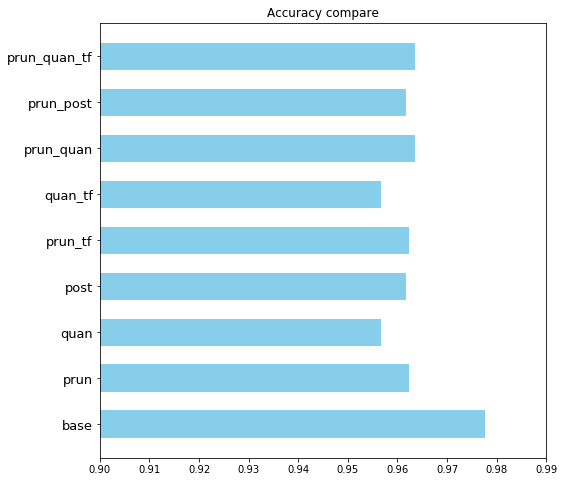

In [43]:
from matplotlib import pyplot as plt

y = [baseline_model_accuracy, model_for_pruning_accuracy,
     q_aware_model_accuracy, test_post_q_accuracy,
     test_accuracy_p, test_accuracy_q,
     q_aware_prun_model_accuracy, test_accuracy_p_post_q, test_accuracy_p_q]

x = ["base", "prun", "quan", "post",
     "prun_tf","quan_tf", "prun_quan",
     "prun_post", "prun_quan_tf"]
plt.figure(figsize=(8, 8))
plt.barh(x, y, color="skyblue", height=0.6)
plt.xlim(0.9, 0.99)

plt.yticks(x,fontsize=13)
plt.title("Accuracy compare")
plt.show()

### 모든 모델의 크기

In [44]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [45]:
print("Size of gzipped baseline Keras model: %.2f bytes\n" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes\n" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped quantizied Keras model: %.2f bytes\n" % (get_gzipped_model_size(quantized_keras_file)))
print("Size of gzipped post-quantized model: %.2f bytes\n" % (get_gzipped_model_size(post_quan_tflite_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes\n" % (get_gzipped_model_size(pruned_tflite_file)))
print("Size of gzipped quantized TFlite model: %.2f bytes\n" % (get_gzipped_model_size(quantized_tflite_file)))
print("Size of gzipped pruned and quantized Keras model: %.2f bytes\n" % (get_gzipped_model_size(pruned_and_quantized_keras_file)))
print("Size of gzipped pruned and post-quantized model: %.2f bytes\n" % (get_gzipped_model_size(post_quantized_and_pruned_tflite_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes\n" % (get_gzipped_model_size(pruned_quantized_tflite_file)))

Size of gzipped baseline Keras model: 77970.00 bytes

Size of gzipped pruned Keras model: 17338.00 bytes

Size of gzipped quantizied Keras model: 33252.00 bytes

Size of gzipped post-quantized model: 144.00 bytes

Size of gzipped pruned TFlite model: 16328.00 bytes

Size of gzipped quantized TFlite model: 7352.00 bytes

Size of gzipped pruned and quantized Keras model: 36050.00 bytes

Size of gzipped pruned and post-quantized model: 5157.00 bytes

Size of gzipped pruned and quantized TFlite model: 10897.00 bytes



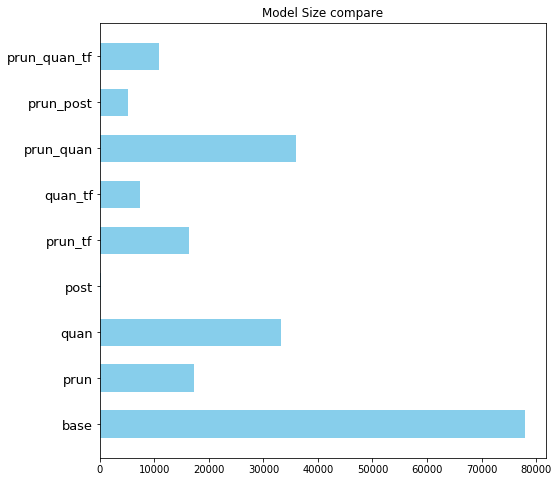

In [46]:
y = [get_gzipped_model_size(keras_file),
     get_gzipped_model_size(pruned_keras_file),
     get_gzipped_model_size(quantized_keras_file),
     get_gzipped_model_size(post_quan_tflite_file),
     get_gzipped_model_size(pruned_tflite_file),
     get_gzipped_model_size(quantized_tflite_file),
     get_gzipped_model_size(pruned_and_quantized_keras_file),
     get_gzipped_model_size(post_quantized_and_pruned_tflite_file),
     get_gzipped_model_size(pruned_quantized_tflite_file)]


x = ["base", "prun", "quan", "post",
     "prun_tf","quan_tf", "prun_quan",
     "prun_post", "prun_quan_tf"]
plt.figure(figsize=(8, 8))
plt.barh(x, y, color="skyblue", height=0.6)
#plt.xlim(0.0,0.9)

plt.yticks(x,fontsize=13)
plt.title("Model Size compare")
plt.show()

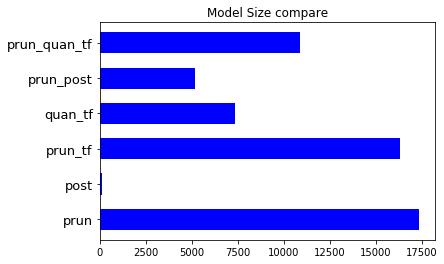

In [47]:
y = [get_gzipped_model_size(pruned_keras_file),
     get_gzipped_model_size(post_quan_tflite_file),
     get_gzipped_model_size(pruned_tflite_file),
     get_gzipped_model_size(quantized_tflite_file),
     get_gzipped_model_size(post_quantized_and_pruned_tflite_file),
     get_gzipped_model_size(pruned_quantized_tflite_file)]

x = ["prun", "post",
     "prun_tf","quan_tf",
     "prun_post", "prun_quan_tf"]

plt.barh(x, y, color="blue", height=0.6)
#plt.xlim(0.0,0.9)

plt.yticks(x,fontsize=13)
plt.title("Model Size compare")
plt.show()

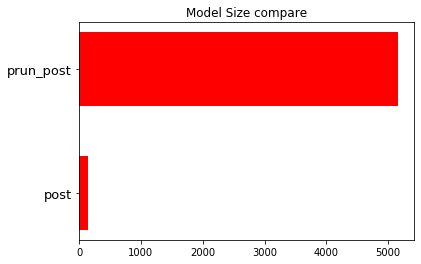

In [48]:
y = [get_gzipped_model_size(post_quan_tflite_file),
     get_gzipped_model_size(post_quantized_and_pruned_tflite_file)]

x = ["post",
     "prun_post"]

plt.barh(x, y, color="red", height=0.6)
#plt.xlim(0.0,0.9)

plt.yticks(x,fontsize=13)
plt.title("Model Size compare")
plt.show()

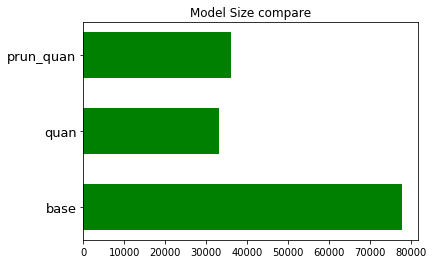

In [50]:
y = [get_gzipped_model_size(keras_file),
     get_gzipped_model_size(quantized_keras_file),
     get_gzipped_model_size(pruned_and_quantized_keras_file)]


x = ["base", "quan", "prun_quan"]

plt.barh(x, y, color="green", height=0.6)


plt.yticks(x,fontsize=13)
plt.title("Model Size compare")
plt.show()

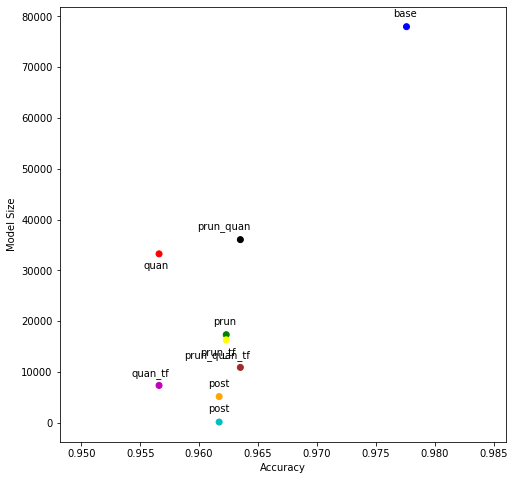

In [58]:
x = [baseline_model_accuracy, model_for_pruning_accuracy,
     q_aware_model_accuracy, test_post_q_accuracy,
     test_accuracy_p, test_accuracy_q,
     q_aware_prun_model_accuracy, test_accuracy_p_post_q, test_accuracy_p_q]

y = [get_gzipped_model_size(keras_file),
     get_gzipped_model_size(pruned_keras_file),
     get_gzipped_model_size(quantized_keras_file),
     get_gzipped_model_size(post_quan_tflite_file),
     get_gzipped_model_size(pruned_tflite_file),
     get_gzipped_model_size(quantized_tflite_file),
     get_gzipped_model_size(pruned_and_quantized_keras_file),
     get_gzipped_model_size(post_quantized_and_pruned_tflite_file),
     get_gzipped_model_size(pruned_quantized_tflite_file)]

z = ["base", "prun", "quan", "post",
     "prun_tf","quan_tf", "prun_quan",
     "prun_post", "prun_quan_tf"]

c = ['b','g','r','c','yellow','m','k','orange',"brown"]
d = [(10,10),(10,10),(10,-15),(10,10),(10,-15),(10,10),(10,10),(10,10),(10,10)]
plt.figure(figsize=(8, 8))
plt.scatter(x,y, color=c)

for xs,ys in zip(x,y):
    plt.annotate(z[x.index(xs)], (xs,ys), textcoords="offset points",xytext=d[x.index(xs)],ha='right')
    
plt.ylabel('Model Size')
plt.xlabel('Accuracy')
plt.show()



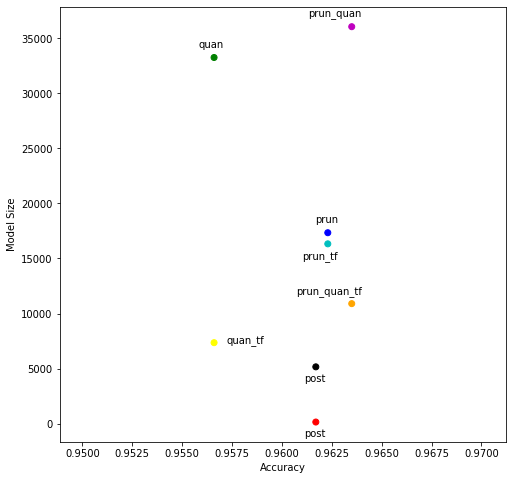

In [62]:
x = [model_for_pruning_accuracy,
     q_aware_model_accuracy, test_post_q_accuracy,
     test_accuracy_p, test_accuracy_q,
     q_aware_prun_model_accuracy, test_accuracy_p_post_q, test_accuracy_p_q]

y = [get_gzipped_model_size(pruned_keras_file),
     get_gzipped_model_size(quantized_keras_file),
     get_gzipped_model_size(post_quan_tflite_file),
     get_gzipped_model_size(pruned_tflite_file),
     get_gzipped_model_size(quantized_tflite_file),
     get_gzipped_model_size(pruned_and_quantized_keras_file),
     get_gzipped_model_size(post_quantized_and_pruned_tflite_file),
     get_gzipped_model_size(pruned_quantized_tflite_file)]

z = ["prun", "quan", "post",
     "prun_tf","quan_tf", "prun_quan",
     "prun_post", "prun_quan_tf"]

c = ['b','g','r','c','yellow','m','k','orange']
d = [(10,10),(10,10),(10,-15),(10,-15),(50,0),(10,10),(10,10),(10,10)]
plt.figure(figsize=(8, 8))
plt.scatter(x,y, color=c)

for xs,ys in zip(x,y):
    plt.annotate(z[x.index(xs)], (xs,ys), textcoords="offset points",xytext=d[x.index(xs)],ha='right')
    
plt.ylabel('Model Size')
plt.xlabel('Accuracy')
plt.show()

